Based on https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [1]:
import re
import os
import time
import random
from IPython import display
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
# Currently seems as though the models take too much memory to run on the GPU (~8GB)
device = "cpu"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

labelled_data_path = "labelled.txt"
models_dir = "models"

# Make sure that these symbols are never in the training data
start_symbol = "<START>"
end_symbol = "<END>"
start_symbol_index = 0  # These values can't change
end_symbol_index = 1   # ^^^

max_sentence_length = 10  # This seems to be a limiting factor memory-wise
teacher_forcing_ratio = 0.5

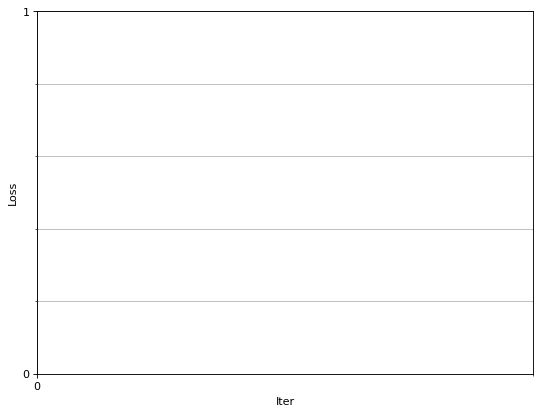

In [3]:
def format_time(seconds):
    if seconds < 60:
        return f"{seconds:.2f}s"
    elif seconds < 3600:
        return f"{(seconds/60):.2f}min"
    else:
        return f"{(seconds/3600):.2f}hr"

fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
ax.set_xlabel("Iter")
ax.set_ylabel("Loss")
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10.0))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=1.0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.2))
ax.grid(which="major", color="#888888")
ax.grid(which="minor", color="#bbbbbb")
fig.patch.set_facecolor("white")

def show_plot(iters, losses):
    for l in ax.lines:
        l.remove()
    ax.plot(iters, losses, c="blue")
    ax.autoscale()
    ax.set_ylim(0, None)
    display.update_display(fig, display_id="loss")

In [4]:
class Style:
    def __init__(self, name):
        self.name = name
        self.words = [start_symbol, end_symbol]
        self.word_to_index = {
            start_symbol: start_symbol_index, end_symbol: end_symbol_index}
        self.word_count = {}

    def add_word(self, word):
        if not word in self.word_to_index:
            self.word_to_index[word] = len(self.words)
            self.words.append(word)
            self.word_count[word] = 1
        else:
            self.word_count[word] += 1

    def add_sentence(self, sentence, max_length=max_sentence_length):
        for word in re.findall(r"[A-Za-z-']+|[^ ]+", sentence)[:max_length-1]:
            self.add_word(word)

    def get_sentence_indices(self, sentence, max_length=max_sentence_length):
        return list(self.word_to_index[word] for word in re.findall(r"[A-Za-z-']+|[^ ]+", sentence) if word in self.word_to_index)[:max_length-1]


def load_styles(style1, style2):
    with open(labelled_data_path, "r") as l:
        lines = [x.strip() for x in l.readlines() if x.strip() != ""]

    pairs = [(lines[i], lines[i+1]) for i in range(0, len(lines), 2)]

    s1 = Style(style1)
    s2 = Style(style2)
    for x, y in pairs:
        s1.add_sentence(x)
        s2.add_sentence(y)

    return s1, s2, pairs

def get_sentence_tensor(style, sentence):
    indices = style.get_sentence_indices(sentence)
    indices.append(end_symbol_index)
    return torch.tensor(indices, dtype=torch.long, device=device).view(-1, 1)


def get_pair_tensors(style1, style2, pair):
    x = get_sentence_tensor(style1, pair[0])
    desired_y = get_sentence_tensor(style2, pair[1])
    return (x, desired_y)

In [5]:
formal, casual, pairs = load_styles("formal", "casual")

In [6]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x).view(1, 1, -1)
        y = embedded
        y, hidden = self.gru(y, hidden)
        return y, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [7]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=max_sentence_length):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.hidden_size)

    def forward(self, x, hidden, encoder_outputs):
        embedded = self.embedding(x).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)),
            dim=1
        )

        attn_applied = torch.bmm(attn_weights.unsqueeze(
            0), encoder_outputs.unsqueeze(0))

        y = torch.cat((embedded[0], attn_applied[0]), 1)
        y = self.attn_combine(y).unsqueeze(0)

        y = F.relu(y)
        y, hidden = self.gru(y, hidden)

        y = F.log_softmax(self.out(y[0]), dim=1)
        return y, hidden, attn_weights

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [8]:
def train(x, desired_y, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max_sentence_length):
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    x_length = x.size(0)
    desired_y_length = desired_y.size(0)

    encoder_outputs = torch.zeros(
        max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(x_length):
        encoder_output, encoder_hidden = encoder(x[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[start_symbol_index]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = random.random() < teacher_forcing_ratio

    if use_teacher_forcing:
        for di in range(desired_y_length):
            decoder_output, decoder_hidden, decoder_attn = decoder(
                decoder_input,
                decoder_hidden,
                encoder_outputs
            )
            loss += criterion(decoder_output, desired_y[di])
            decoder_input = desired_y[di]

    else:
        for di in range(desired_y_length):
            decoder_output, decoder_hidden, decoder_attn = decoder(
                decoder_input,
                decoder_hidden,
                encoder_outputs
            )
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, desired_y[di])
            if decoder_input.item() == end_symbol_index:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / desired_y_length

In [9]:
def train_iters(pair_tensors, encoder, decoder, n_iters, print_every=1000, plot_every=100, save_every=100, learning_rate=0.01):
    start = time.time()
    plot_iters = []
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    saves = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [random.choice(pair_tensors) for _ in range(n_iters)]
    criterion = nn.NLLLoss()
    print("Training...")
    for iter, (x, desired_y) in enumerate(training_pairs):
        loss = train(x, desired_y, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if (iter + 1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            elapsed = time.time() - start
            print(f"Iter [{iter+1}/{n_iters}] - {(100 * (iter+1)/n_iters):.4f}%, Elapsed: {format_time(elapsed)}, ETA: {format_time(elapsed/(iter+1) * (n_iters - iter - 1))}, Avg loss: {print_loss_avg:.5f}")

        if (iter + 1) % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_loss_total = 0
            plot_iters.append(iter+1)
            plot_losses.append(plot_loss_avg)

            show_plot(plot_iters, plot_losses)
        
        if (iter + 1) % save_every == 0:
            torch.save(encoder, os.path.join(models_dir, f"encoder-{saves:04d}-{loss:.5f}.pkl"))
            torch.save(decoder, os.path.join(models_dir, f"decoder-{saves:04d}-{loss:.5f}.pkl"))
            saves += 1

In [10]:
def evaluate(encoder, decoder, sentence, input_style, output_style, max_length=max_sentence_length):
    with torch.no_grad():
        x = get_sentence_tensor(input_style, sentence)
        x_length = x.size(0)
        encoder_hidden = encoder.init_hidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(x_length):
            encoder_output, encoder_hidden = encoder(x[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[start_symbol_index]], device=device)

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input,
                decoder_hidden,
                encoder_outputs
            )
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == end_symbol_index:
                decoded_words.append(end_symbol)
                break
            else:
                decoded_words.append(output_style.words[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [11]:
# WARNING: DELETES ALL CHECKPOINTS
if not os.path.isdir(models_dir):
    os.makedirs(models_dir)

for f in os.listdir(models_dir):
    os.unlink(os.path.join(models_dir, f))

In [12]:
hidden_size = max(256, max(len(formal.words), len(casual.words)) + 1)
print(f"Creating new models with hidden size: {hidden_size}...")
pair_tensors = [get_pair_tensors(formal, casual, pair) for pair in pairs]

encoder = EncoderRNN(len(formal.words), hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, len(casual.words)).to(device)

Creating new models with hidden size: 6625...


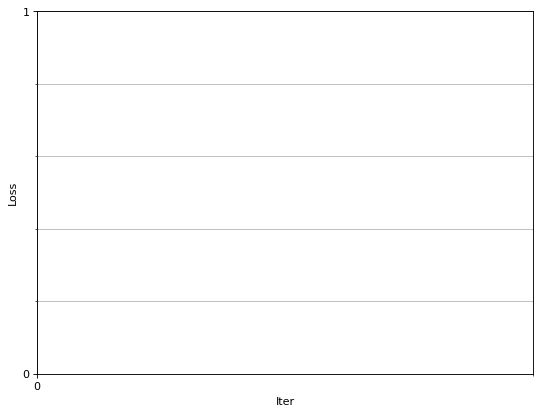

Training...


KeyboardInterrupt: 

In [13]:
display.display(fig, display_id="loss")

train_iters(pair_tensors, encoder, attn_decoder, 1000, print_every=10, plot_every=10, save_every=50)

In [ ]:
all_models = sorted(os.listdir(models_dir))
encoder_models = [m for m in all_models if m.startswith("encoder")]
decoder_models = [m for m in all_models if m.startswith("decoder")]

encoder_model = os.path.join(models_dir, encoder_models[-1])
decoder_model = os.path.join(models_dir, decoder_models[-1])

# Ensure that the models are from the same checkpoint
assert encoder_model.replace("encoder", "") == decoder_model.replace("decoder", "")

print(f"Loading encoder from '{encoder_model}'...")
print(f"Loading decoder from '{decoder_model}'...")
print("\n\n")

encoder = torch.load(encoder_model)
decoder = torch.load(decoder_model)

In [ ]:
sentence = "You should seek medical attention."

print(f"\"{sentence}\"")
print("->")
start = time.time()
decoded_words, _ = evaluate(encoder, decoder, sentence, formal, casual)
elapsed = time.time()-start
print(decoded_words)
print(f"\nTook {format_time(elapsed)}.")